## Algorithm Used

**CNN Encoder**  
We use a pretrained InceptionV3 (minus its final softmax) to turn each image into a 2048‑dim feature vector. A dropout layer and dense projection then prepare these features for merging with the text decoder.

**LSTM Decoder**  
Captions are tokenized, padded, and passed through a 256‑dim embedding layer into an LSTM. At each time step, the LSTM predicts the next word in the sequence until an end token is produced.

**Feature–Text Fusion**  
The image feature vector and the LSTM’s hidden state are combined via element‑wise addition, and a final dense+softmax layer produces a probability over the vocabulary for the next word.

**Training & Inference**  
During training we use teacher forcing and minimize cross‑entropy loss. At inference, we start from a “startseq” token and greedily sample words until “endseq” or a length limit is reached.


# ————————————
# 1. Imports
# ————————————

In [ ]:
import os
import csv
import string
import numpy as np
from pickle import dump, load
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

# ————————————
# 2. CONFIGURATION
# ————————————

In [ ]:
IMAGES_DIR     = '../Flickr8k//images/'
CAPTIONS_FILE  = '../Flickr8k/captions.txt'
FEATURES_FILE  = './image_features.pkl'
TOKENIZER_FILE = './tokenizer.pkl'

MAX_IMAGES     = 2000
VOCAB_SIZE     = 5000
MAX_LENGTH     = 34
EMBED_DIM      = 256
BATCH_SIZE     = 64
EPOCHS         = 20

# ————————————
# 3. Defining Functions
# ————————————

In [ ]:
# FUNTION TO LOAD & TRUNCATE CAPTIONS

def load_captions_csv(filename):
    captions = {}
    with open(filename, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            img = row['image'].strip()
            cap = row['caption'].lower().translate(
                str.maketrans('', '', string.punctuation)
            )
            cap = f"startseq {cap} endseq"
            captions.setdefault(img, []).append(cap)
    return captions

##################################################################################################################

# load all, then keep only first MAX_IMAGES
all_captions = load_captions_csv(CAPTIONS_FILE)
selected_imgs = list(all_captions.keys())[:MAX_IMAGES]
captions = {img: all_captions[img] for img in selected_imgs}
print(f"Loaded captions for {len(captions)} images (truncated to {MAX_IMAGES}).")

##################################################################################################################

# FUNCTION TO EXTRACT (OR LOAD) IMAGE FEATURES
def extract_features(directory, images_list):
    base_model = InceptionV3(weights='imagenet')
    model = Model(base_model.input, base_model.layers[-2].output)
    features = {}
    for img_name in tqdm(images_list, desc="Extracting features"):
        path = os.path.join(directory, img_name)
        try:
            img = tf.keras.preprocessing.image.load_img(path, target_size=(299,299))
            x   = tf.keras.preprocessing.image.img_to_array(img)
            x   = np.expand_dims(x, axis=0)
            x   = preprocess_input(x)
            feat = model.predict(x, verbose=0).flatten()
            features[img_name] = feat
        except Exception:
            continue
    return features

##################################################################################################################


# Load image features from cache if available, otherwise extract and save them

if os.path.exists(FEATURES_FILE):
    all_feats = load(open(FEATURES_FILE, 'rb'))
    image_features = {img: all_feats[img] for img in selected_imgs if img in all_feats}
    print(f"Loaded cached features for {len(image_features)} images.")
else:
    image_features = extract_features(IMAGES_DIR, selected_imgs)
    dump(image_features, open(FEATURES_FILE, 'wb'))
    print(f"Extracted & saved features for {len(image_features)} images.")

##################################################################################################################

#TOKENIZER SETUP

all_texts = [c for caps in captions.values() for c in caps]
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='unk')
tokenizer.fit_on_texts(all_texts)
dump(tokenizer, open(TOKENIZER_FILE, 'wb'))
print(f"Tokenizer fitted on {len(tokenizer.word_index)} unique tokens (capped at {VOCAB_SIZE}).")

##################################################################################################################

#CREATE TRAINING SEQUENCES
def create_sequences(tok, max_len, caps_list, img_feat):
    X1, X2, y = [], [], []
    seqs = tok.texts_to_sequences(caps_list)
    for seq in seqs:
        for i in range(1, len(seq)):
            in_seq, out_word = seq[:i], seq[i]
            in_pad = pad_sequences([in_seq], maxlen=max_len, padding='post')[0]
            out_enc = to_categorical([out_word], num_classes=VOCAB_SIZE)[0]
            X1.append(img_feat)
            X2.append(in_pad)
            y.append(out_enc)
    return np.array(X1), np.array(X2), np.array(y)

X1_list, X2_list, y_list = [], [], []
for img, caps in captions.items():
    if img not in image_features:
        continue
    feats = image_features[img]
    sx1, sx2, sy = create_sequences(tokenizer, MAX_LENGTH, caps, feats)
    X1_list.append(sx1); X2_list.append(sx2); y_list.append(sy)

X1 = np.vstack(X1_list)
X2 = np.vstack(X2_list)
y  = np.vstack(y_list)
print(f"Training data shapes: {X1.shape}, {X2.shape}, {y.shape}")

##################################################################################################################

#BUILD THE MODEL

# Encoder: image features
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(EMBED_DIM, activation='relu')(fe1)

# Decoder: sequences
inputs2 = Input(shape=(MAX_LENGTH,))
se1 = Embedding(VOCAB_SIZE, EMBED_DIM, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# Merge & output
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs  = Dense(VOCAB_SIZE, activation='softmax')(decoder2)

##################################################################################################################

# DEFINE THE MODEL
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

##################################################################################################################

#TRAINING THE MODEL
checkpoint = ModelCheckpoint('best_image_caption.h5',
                             monitor='loss', save_best_only=True, verbose=1)
model.fit([X1, X2], y,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          callbacks=[checkpoint])

##################################################################################################################

# DEFINING A FUNCTION FOR INFERENCE
def generate_caption(model, tok, img_feat, max_len=MAX_LENGTH):
    in_text = 'startseq'
    for _ in range(max_len):
        seq = tok.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], maxlen=max_len, padding='post')
        yhat = model.predict([img_feat.reshape((1,2048)), seq], verbose=0)
        word_idx = np.argmax(yhat)
        word = tok.index_word.get(word_idx, 'unk')
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text.replace('startseq ', '').replace(' endseq', '')

Loaded captions for 2000 images (truncated to 2000).
96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


Extracting features: 100%|██████████| 2000/2000 [03:52<00:00,  8.60it/s]


Extracted & saved features for 2000 images.
Tokenizer fitted on 4541 unique tokens (capped at 5000).
Training data shapes: (119142, 2048), (119142, 34), (119142, 5000)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 256)   │  1,280,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 34, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 34)        │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 5000)      │  1,285,000 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,680,648 (14.04 MB)

 Trainable params: 3,680,648 (14.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1861/1862 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 4.7157
Epoch 1: loss improved from inf to 4.20028, saving model to best_image_caption.h5


1862/1862 ━━━━━━━━━━━━━━━━━━━━ 89s 46ms/step - loss: 4.7151
Epoch 2/20
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 3.4701
Epoch 2: loss improved from 4.20028 to 3.41194, saving model to best_image_caption.h5


1862/1862 ━━━━━━━━━━━━━━━━━━━━ 86s 46ms/step - loss: 3.4700
Epoch 3/20
1861/1862 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 3.0867
Epoch 3: loss improved from 3.41194 to 3.07963, saving model to best_image_caption.h5


1862/1862 ━━━━━━━━━━━━━━━━━━━━ 88s 47ms/step - loss: 3.0867
Epoch 4/20
1861/1862 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 2.8376
Epoch 4: loss improved from 3.07963 to 2.84564, saving model to best_image_caption.h5


1862/1862 ━━━━━━━━━━━━━━━━━━━━ 93s 50ms/step - loss: 2.8376
Epoch 5/20
1861/1862 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 2.6489
Epoch 5: loss improved from 2.84564 to 2.66243, saving model to best_image_caption.h5


1862/1862 ━━━━━━━━━━━━━━━━━━━━ 84s 45ms/step - loss: 2.6489
Epoch 6/20
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 2.4779
Epoch 6: loss improved from 2.66243 to 2.50841, saving model to best_image_caption.h5


1862/1862 ━━━━━━━━━━━━━━━━━━━━ 100s 54ms/step - loss: 2.4779
Epoch 7/20
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 2.3514
Epoch 7: loss improved from 2.50841 to 2.37776, saving model to best_image_caption.h5


1862/1862 ━━━━━━━━━━━━━━━━━━━━ 433s 233ms/step - loss: 2.3514
Epoch 8/20
1861/1862 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 2.2265
Epoch 8: loss improved from 2.37776 to 2.26223, saving model to best_image_caption.h5


1862/1862 ━━━━━━━━━━━━━━━━━━━━ 272s 146ms/step - loss: 2.2265
Epoch 9/20
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 2.1253
Epoch 9: loss improved from 2.26223 to 2.16538, saving model to best_image_caption.h5


1862/1862 ━━━━━━━━━━━━━━━━━━━━ 393s 211ms/step - loss: 2.1253
Epoch 10/20
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 2.0341
Epoch 10: loss improved from 2.16538 to 2.07435, saving model to best_image_caption.h5


1862/1862 ━━━━━━━━━━━━━━━━━━━━ 118s 63ms/step - loss: 2.0341
Epoch 11/20
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.9598
Epoch 11: loss improved from 2.07435 to 1.99984, saving model to best_image_caption.h5


1862/1862 ━━━━━━━━━━━━━━━━━━━━ 85s 46ms/step - loss: 1.9598
Epoch 12/20
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 1.8852
Epoch 12: loss improved from 1.99984 to 1.93370, saving model to best_image_caption.h5


1862/1862 ━━━━━━━━━━━━━━━━━━━━ 168s 90ms/step - loss: 1.8853
Epoch 13/20
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 1.8293
Epoch 13: loss improved from 1.93370 to 1.87294, saving model to best_image_caption.h5


1862/1862 ━━━━━━━━━━━━━━━━━━━━ 161s 86ms/step - loss: 1.8294
Epoch 14/20
1861/1862 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.7750
Epoch 14: loss improved from 1.87294 to 1.81968, saving model to best_image_caption.h5


1862/1862 ━━━━━━━━━━━━━━━━━━━━ 83s 44ms/step - loss: 1.7750
Epoch 15/20
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.7212
Epoch 15: loss improved from 1.81968 to 1.77054, saving model to best_image_caption.h5


1862/1862 ━━━━━━━━━━━━━━━━━━━━ 83s 45ms/step - loss: 1.7212
Epoch 16/20
1861/1862 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 1.6808
Epoch 16: loss improved from 1.77054 to 1.72896, saving model to best_image_caption.h5


1862/1862 ━━━━━━━━━━━━━━━━━━━━ 89s 48ms/step - loss: 1.6809
Epoch 17/20
1861/1862 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.6387
Epoch 17: loss improved from 1.72896 to 1.68985, saving model to best_image_caption.h5


1862/1862 ━━━━━━━━━━━━━━━━━━━━ 81s 44ms/step - loss: 1.6388
Epoch 18/20
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.6037
Epoch 18: loss improved from 1.68985 to 1.65723, saving model to best_image_caption.h5


1862/1862 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - loss: 1.6037
Epoch 19/20
1861/1862 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.5715
Epoch 19: loss improved from 1.65723 to 1.62013, saving model to best_image_caption.h5


1862/1862 ━━━━━━━━━━━━━━━━━━━━ 84s 45ms/step - loss: 1.5715
Epoch 20/20
1861/1862 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 1.5441
Epoch 20: loss improved from 1.62013 to 1.59080, saving model to best_image_caption.h5


1862/1862 ━━━━━━━━━━━━━━━━━━━━ 90s 48ms/step - loss: 1.5441


# ————————————
# 4. Inference
# ————————————

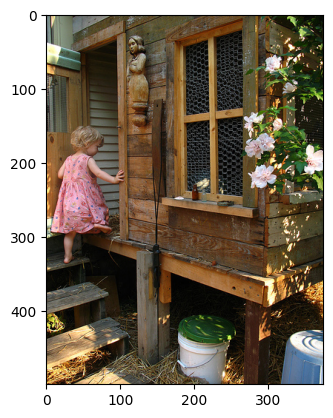

a woman in a blue shirt and jeans is standing in front of a fountain


In [21]:
from PIL import Image
import matplotlib.pyplot as plt
import os

image_pth = '1000268201_693b08cb0e.jpg'

feat = image_features[image_pth]

im = Image.open(os.path.join('./Images', image_pth))
plt.imshow(im)
plt.show()

print(generate_caption(model, tokenizer, feat))

## Results

**Training Outcomes (Epoch 1–20)**

i. **Initial Loss (Epoch 1):** 4.715  
ii. **Final Loss (Epoch 20):** 1.544  
iii. **Overall Reduction:** ~3.17 points  

The model’s training loss decreased at every epoch this indicates convergence in the model training.

**Inferences**

1. **Convergence**  
   By epoch 10 the loss had fallen to ~2.03, and by epoch 20 it reached ~1.54. The improvements after epoch 15 are very less that suggest the model is approaching its capacity on this dataset without over‑fitting.

2. **Remaining Error**  
   A training loss of ~1.54 tells that the model still makes word‑prediction errors.

3. **Prediction Quality**  
   The example inference (“a woman in a blue shirt and jeans is standing in front of a fountain”) is clearly incorrect for the provided image. This denotes that:

   i. The decoder defaults to high‑frequency patterns (“woman,” “fountain”) when uncertain.

   ii. The model needs stronger visual grounding (attention) or more diverse training captions.